## DNN model for estimating the difference between closed form implied volatility and numerially calculated implied volatility

#### Background: Following the link that Peter shared : https://hpcquantlib.wordpress.com/2019/01/11/finite-difference-solver-for-the-sabr-model/. The network is trained to fit the difference between the 'exact' SABR volatility from the solution of the partial differential equation and the Floc’h-Kennedy approximation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import warnings
import swifter
import torch.optim as optim
import QuantLib as ql

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_absolute_error
from scipy.optimize import minimize
from scipy.stats import norm

warnings.filterwarnings('ignore')

### 1. Problems that wait to be solved

#### a.  Verify our calculated implid valitility of  Floc'h and Hagan to those shown in  blog with the same parameters
#### b.  Finite difference method with boundaries limits
#### c.  Finite difference method without boundaries limits ( replicated results compared with refered paper)
#### d.  Mento carlo method 
#### e.  Construce DNN model to learn the difference between volitilites
#### f.   DNN model to predict implied volatility with static parameters

### part a Verify our calculated implid valitility of Floc'h and Hagan to those shown in blog with the same parameters

In [2]:
f0=1.0

In [3]:
def plot_floch_hagan(alpha, beta, nu, rho, tenor,strike_min, strike_max):
    strikes=np.linspace(strike_min,strike_max,20)
    sabr_vol=[ql.sabrVolatility(strike,f0,tenor,alpha,beta, nu, rho) for strike in strikes]
    sabr_floch_vol=[ql.sabrFlochKennedyVolatility(strike,f0,tenor,alpha,beta,nu,rho) for strike in strikes]
    plt.plot(strikes,sabr_vol,linestyle='dashed',marker='^',label='Hagan_sabr')
    plt.plot(strikes,sabr_floch_vol,linestyle='dashed',marker='o',label='floch_sabr')
    plt.legend()
    plt.show()
def draw_trisurf(x, y, z, title, x_axis='K', y_axis='T'):
    fig = plt.figure(figsize =(16, 9))  
    ax = plt.axes(projection ='3d')  

    # Creating color map
    my_cmap = plt.get_cmap('RdBu_r')

    # Creating plot
    trisurf = ax.plot_trisurf(x, y, z,
                             cmap = my_cmap,
                             linewidth = 0.2, 
                             antialiased = True,
                             edgecolor = 'grey')  
    fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
    ax.set_title(title)
    ax.set_xlabel(x_axis, fontsize=15, rotation=60)
    ax.set_ylabel(y_axis, fontsize=15, rotation=60)
    ax.set_zlabel(title, fontsize=15)
    plt.show()   

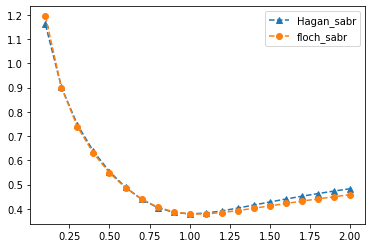

In [4]:
alpha,beta,nu,rho,tenor, strike_min, strike_max = 0.35, 0.25, 1.0, 0.25, 1, 0.1, 2
plot_floch_hagan(alpha, beta, nu, rho, tenor,strike_min, strike_max)

The above plot matches the one posted in the original blog, with maturity equaling 1. However, when we change the maturity to 3, the difference between Floch and Hagan is huge regarding to deep OTM options. which can be seen below.

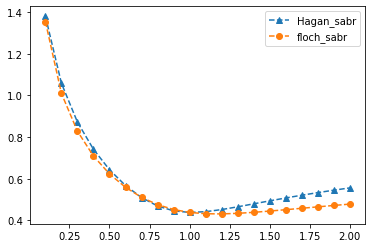

In [5]:
alpha,beta,nu,rho,tenor, strike_min, strike_max = 0.35, 0.25, 1.0, 0.25,3, 0.1, 2
plot_floch_hagan(alpha, beta, nu, rho, tenor,strike_min, strike_max)

What if we change the correlation paramter $\rho$ to negative value, and compare the plots of two different maturities

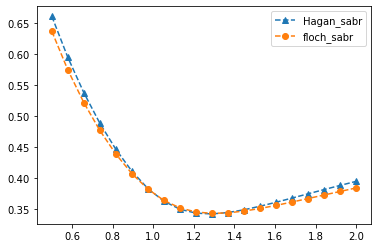

In [6]:
alpha,beta,nu,rho,tenor, strike_min, strike_max = 0.35, 0.25, 1.0, -0.25, 1 , 0.5, 2
plot_floch_hagan(alpha, beta, nu, rho, tenor,strike_min, strike_max)

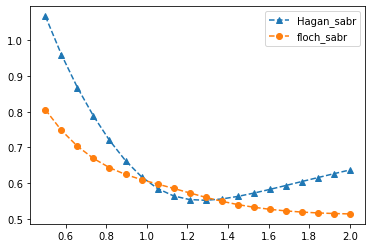

In [7]:
alpha,beta,nu,rho,tenor, strike_min, strike_max = 0.35, 0.25, 1.0, -0.25, 10, 0.5, 2
plot_floch_hagan(alpha, beta, nu, rho, tenor,strike_min, strike_max)

### part b Finite difference method with boundaries limits

In [8]:
def fdm_implied_price(r0,f0,strike,expiry,alpha,beta,nu,rho):
    today = ql.Date().todaysDate()
    yieldTermStructure = ql.YieldTermStructureHandle(ql.FlatForward(today,r0, ql.Actual360()))
    engine=ql.FdSabrVanillaEngine(f0,alpha, beta, nu,rho, yieldTermStructure)
    expiry_date = today+int(365*(expiry))
    option = ql.EuropeanOption(ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(expiry_date))
    option.setPricingEngine(engine)
    try:
        price=option.NPV()
    except RuntimeError:
        return None
    return price

# Now we're assuming that S_0 is 1
def fdm_price(row):
    return fdm_implied_price(0.,1,row[4],row[5],row[0],row[2],row[1],row[3])

### Finite difference method without boundaries limits
#### This part is coded in Matlab, the results are read from saved file 'fdm_hagan_floch_newdata.csv', in the following analysis,  'fdm-price' refers to price from Matlab code, while 'fdm_price-ql' indicated price from QuantLib

In [9]:
data = pd.read_csv('fdm_hagan_floch_newdata.csv')

In [10]:
data.describe()

,alpha,nu,beta,rho,strike,tenor,hagan_vol,floch_vol,fdm_price,fdm_vol
count,641410.000000,641410.000000,641410.000000,641410.000000,641410.000000,641410.000000,641410.000000,641410.000000,627776.000000,6.414100e+05
mean,0.500000,0.557143,0.442857,-0.300000,1.235294,3.821429,0.530216,0.527991,0.307373,6.101146e-01
std,0.244949,0.261081,0.277010,0.316228,0.451066,3.424479,0.287072,0.284605,0.279788,8.309463e-01
min,0.100000,0.100000,0.100000,-0.800000,0.500000,0.250000,-0.679563,-0.827982,0.000000,3.885781e-16
25%,0.300000,0.300000,0.200000,-0.600000,0.900000,0.500000,0.307665,0.307030,0.058205,2.933594e-01
50%,0.500000,0.600000,0.400000,-0.300000,1.200000,3.000000,0.501192,0.500932,0.249991,4.898438e-01
75%,0.700000,0.800000,0.600000,0.000000,1.600000,7.000000,0.709912,0.707110,0.498316,6.957031e-01
max,0.900000,0.900000,1.000000,0.200000,2.000000,10.000000,2.760727,2.698490,2.114333,1.043000e+01


In [21]:
data.head(10)

,alpha,nu,beta,rho,strike,tenor,hagan_vol,floch_vol,fdm_price,fdm_vol
0,0.1,0.1,0.1,-0.8,0.5,0.25,0.161508,0.161946,0.500000,0.160000
1,0.1,0.1,0.1,-0.8,0.5,0.50,0.161523,0.161967,0.500000,0.100000
2,0.1,0.1,0.1,-0.8,0.5,1.00,0.161555,0.162009,0.500000,0.060000
3,0.1,0.1,0.1,-0.8,0.5,3.00,0.161681,0.162176,0.500447,0.162656
4,0.1,0.1,0.1,-0.8,0.5,5.00,0.161807,0.162343,0.502762,0.162656
5,0.1,0.1,0.1,-0.8,0.5,7.00,0.161933,0.162510,0.506791,0.162734
6,0.1,0.1,0.1,-0.8,0.5,10.00,0.162122,0.162761,0.514690,0.162891
7,0.1,0.1,0.1,-0.7,0.5,0.25,0.159079,0.159487,0.500000,0.160000
8,0.1,0.1,0.1,-0.7,0.5,0.50,0.159104,0.159514,0.500000,0.100000
9,0.1,0.1,0.1,-0.7,0.5,1.00,0.159152,0.159567,0.500000,0.060000


In [12]:
sample = data.sample(1000)

In [13]:
sample.describe()

,alpha,nu,beta,rho,strike,tenor,hagan_vol,floch_vol,fdm_price,fdm_vol
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,983.000000,1.000000e+03
mean,0.512000,0.560900,0.438600,-0.296700,1.228500,3.793250,0.543259,0.541738,0.316279,6.070927e-01
std,0.246448,0.265879,0.273688,0.315434,0.454185,3.392023,0.289328,0.287254,0.280627,7.768240e-01
min,0.100000,0.100000,0.100000,-0.800000,0.500000,0.250000,-0.068173,0.008532,0.000000,3.885781e-16
25%,0.300000,0.300000,0.200000,-0.600000,0.900000,0.500000,0.323648,0.324511,0.059941,3.033984e-01
50%,0.500000,0.600000,0.400000,-0.300000,1.200000,3.000000,0.511245,0.513025,0.265771,5.006641e-01
75%,0.700000,0.800000,0.600000,0.000000,1.600000,7.000000,0.733154,0.726854,0.503990,7.193750e-01
max,0.900000,0.900000,1.000000,0.200000,2.000000,10.000000,1.855589,1.837227,1.612031,7.870000e+00


In [14]:
sample['fdm_price_ql'] = np.apply_along_axis(fdm_price,1,sample)

In [15]:
print(sample.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 106708 to 415531
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alpha         1000 non-null   float64
 1   nu            1000 non-null   float64
 2   beta          1000 non-null   float64
 3   rho           1000 non-null   float64
 4   strike        1000 non-null   float64
 5   tenor         1000 non-null   float64
 6   hagan_vol     1000 non-null   float64
 7   floch_vol     1000 non-null   float64
 8   fdm_price     983 non-null    float64
 9   fdm_vol       1000 non-null   float64
 10  fdm_price_ql  805 non-null    float64
dtypes: float64(11)
memory usage: 93.8 KB
None


We can see that the pricing engine in QuantLib is not that reliable, as there are 195 None values in randomly picked 1000 sample data. For our pricing model coded in Matlab, the number of None values is 17 because of singular matrix.

### part d Monte carlo method

In [16]:
MC_data = pd.read_csv('CompareData.csv') # read Monte Carlo implied vol and Quantlib implied vol

In [17]:
MC_data['diff'] = MC_data.value - MC_data.fdm_value

#### Compare Monte Carlo with FDM Matlab

In [18]:
def draw_trisurf(x, y, z, title, x_axis='K', y_axis='T'):
    fig = plt.figure(figsize =(16, 9))  
    ax = plt.axes(projection ='3d')  

    # Creating color map
    my_cmap = plt.get_cmap('RdBu_r')

    # Creating plot
    trisurf = ax.plot_trisurf(x, y, z,
                             cmap = my_cmap,
                             linewidth = 0.2, 
                             antialiased = True,
                             edgecolor = 'grey')  
    fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
    ax.set_title(title)
    ax.set_xlabel(x_axis, fontsize=15, rotation=60)
    ax.set_ylabel(y_axis, fontsize=15, rotation=60)
    ax.set_zlabel(title, fontsize=15)
    plt.show()

In [19]:
MC_data['diff'].describe()

count    299988.000000
mean         -0.003083
std           0.008982
min          -0.074841
25%          -0.000403
50%          -0.000052
75%           0.000020
max           0.003874
Name: diff, dtype: float64

                  0
count  2.999880e+05
mean   3.238280e-03
std    8.927211e-03
min    1.205576e-09
25%    3.996300e-05
50%    1.418862e-04
75%    6.085266e-04
max    7.484124e-02


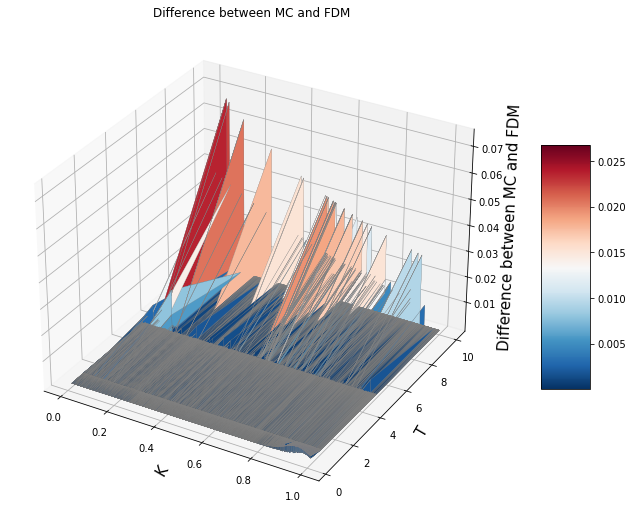

In [20]:
z = np.abs(MC_data['diff'].values)
x = MC_data.strike
y = MC_data.tenor
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, 'Difference between MC and FDM')

### part e Compare Closed form method with FDM Matlab
#### Data filter and check

In [22]:
data.query('fdm_price > 0.1').describe()

,alpha,nu,beta,rho,strike,tenor,hagan_vol,floch_vol,fdm_price,fdm_vol
count,430269.000000,430269.000000,430269.000000,430269.000000,430269.000000,430269.000000,430269.000000,430269.000000,430269.000000,430269.000000
mean,0.552432,0.553841,0.428936,-0.288172,1.083341,4.656937,0.615609,0.612693,0.435475,0.752202
std,0.230126,0.260935,0.264890,0.314677,0.425219,3.377624,0.278930,0.276551,0.248254,0.973593
min,0.100000,0.100000,0.100000,-0.800000,0.500000,0.250000,-0.023337,-0.109151,0.100001,0.020000
25%,0.400000,0.300000,0.200000,-0.600000,0.700000,1.000000,0.414659,0.414680,0.236311,0.409609
50%,0.500000,0.600000,0.400000,-0.300000,1.000000,5.000000,0.589325,0.587037,0.400901,0.578516
75%,0.700000,0.800000,0.600000,0.000000,1.400000,7.000000,0.791206,0.787589,0.572675,0.782813
max,0.900000,0.900000,1.000000,0.200000,2.000000,10.000000,2.760727,2.698490,2.114333,10.430000


In [23]:
data.query('fdm_price > 0.1 and fdm_vol !=0.1 and fdm_vol != 0.06').describe()

,alpha,nu,beta,rho,strike,tenor,hagan_vol,floch_vol,fdm_price,fdm_vol
count,429291.000000,429291.000000,429291.000000,429291.000000,429291.000000,429291.000000,429291.000000,429291.000000,429291.000000,429291.000000
mean,0.553430,0.554092,0.428806,-0.288303,1.084519,4.666649,0.616570,0.613648,0.435478,0.753688
std,0.229429,0.260882,0.264815,0.314674,0.424976,3.375194,0.278513,0.276132,0.248523,0.974203
min,0.100000,0.100000,0.100000,-0.800000,0.500000,0.250000,-0.023337,-0.109151,0.100001,0.020000
25%,0.400000,0.300000,0.200000,-0.600000,0.700000,1.000000,0.415954,0.415999,0.235938,0.410938
50%,0.500000,0.600000,0.400000,-0.300000,1.000000,5.000000,0.590233,0.587892,0.400995,0.579297
75%,0.700000,0.800000,0.600000,0.000000,1.400000,7.000000,0.791736,0.788125,0.573202,0.783359
max,0.900000,0.900000,1.000000,0.200000,2.000000,10.000000,2.760727,2.698490,2.114333,10.430000


#### Helper function for finding implied vol

In [24]:
def bscall(f0,k,t,sigma,r):
    d1=(np.log(f0/k)+sigma**2/2*t)/(sigma*np.sqrt(t))
    d2=d1-sigma*np.sqrt(t)    
    return np.exp(-r*t)*(f0*norm.cdf(d1)-k*norm.cdf(d2))

def bs_vega(f0,k,t,sigma,r):
    d1=(np.log(f0/k)+sigma**2/2*t)/(sigma*np.sqrt(t))
    dd1= 1/np.sqrt(t) * (np.log(f0/k) * (-1/sigma**2)  + 1/2 * t)
    return np.exp(-r*t)*(f0 * norm.pdf(d1) * dd1 + k* norm.pdf(d1-sigma*np.sqrt(t)) * (dd1 - np.sqrt(t)))

def find_vol(target_value, S, K, T, r):
    MAX_ITERATIONS = 200
    PRECISION = 1.0e-20

    sigma = 0.3
    for i in range(0, MAX_ITERATIONS):
        price = bscall( S, K, T, sigma,r)
        vega = bs_vega( S, K, T, sigma, r)

        price = price
        diff = target_value - price  # our root

        print (i, sigma, diff)

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma
def opt_vol(vol,para):
    f0=para[0]
    strike=para[1]
    t=para[2]
    r=para[3]
    price=para[4]
    diff = price-bscall(f0,strike,t,vol,r)
    print(f'differience between two price is {diff}')
    return np.abs(price-bscall(f0,strike,t,vol,r))
def implied_vol(r0,f0,strike,expiry,price_fdm):
    para_fdm=[f0,strike,expiry,r0,price_fdm]
    fdm_vol=minimize(opt_vol,0.5,para_fdm, method='Nelder-Mead',options={'gtol': 1e-22}, maxiter= 500).x
    return fdm_vol[0]

In [28]:
# Add some filter condition to make the analysis more reasonable
filter_data= data.query('fdm_price > 0.1 and fdm_vol>0.1 \
                         and alpha >0.1 and alpha < 0.5 \
                         and beta >0.1 and beta <0.5 \
                         and rho <0').reset_index().drop(columns='index')
df_train = filter_data.copy()
df_train['diff_floch'] = df_train['floch_vol']-df_train['fdm_vol']
df_train=df_train.query('diff_floch> -1 and diff_floch <1')
df_train['diff'] = df_train['hagan_vol']-df_train['fdm_vol']
df_train=df_train.query('diff > -1 and diff <1')
df_train.describe()

,alpha,nu,beta,rho,strike,tenor,hagan_vol,floch_vol,fdm_price,fdm_vol,diff_floch,diff
count,34304.000000,34304.00000,34304.000000,34304.000000,34304.000000,34304.000000,34304.000000,34304.000000,34304.000000,34304.000000,34304.000000,34304.000000
mean,0.312599,0.56729,0.300166,-0.435054,0.995382,5.138067,0.378967,0.373582,0.330618,0.369706,0.003876,0.009261
std,0.080359,0.26025,0.081650,0.227440,0.384981,3.446413,0.121579,0.111539,0.166944,0.115550,0.018052,0.021777
min,0.200000,0.10000,0.200000,-0.800000,0.500000,0.250000,0.119231,0.154251,0.100001,0.150312,-0.490051,-0.324880
25%,0.200000,0.30000,0.200000,-0.600000,0.700000,1.000000,0.290435,0.291403,0.190099,0.286094,-0.000115,0.000051
50%,0.300000,0.60000,0.300000,-0.400000,0.900000,5.000000,0.365363,0.362338,0.303568,0.356250,0.001060,0.002100
75%,0.400000,0.80000,0.400000,-0.200000,1.200000,7.000000,0.448232,0.439907,0.451121,0.434453,0.006563,0.012171
max,0.400000,0.90000,0.400000,-0.100000,2.000000,10.000000,1.043713,0.885120,0.978663,1.368594,0.187138,0.230786


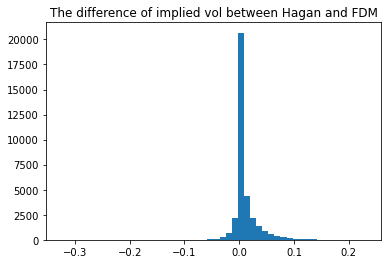

In [29]:
plt.hist(df_train['diff'], bins=50)
plt.title('The difference of implied vol between Hagan and FDM')
plt.show()

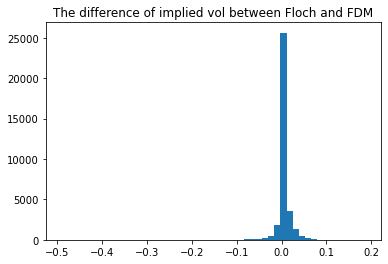

In [31]:
plt.hist(df_train['diff_floch'], bins=50)
plt.title('The difference of implied vol between Floch and FDM')
plt.show()

### part f  DNN Model Training

#### Model 1: The training target would be to minimize the difference between hagan method and finite difference method

In [323]:
df_train.query("strike>0.9 and strike<1.1 and tenor > 0.9 and tenor < 1.1")['hagan_vol'].describe()

count    672.000000
mean       0.355409
std        0.051201
min        0.294735
25%        0.302793
50%        0.355391
75%        0.403690
max        0.427582
Name: hagan_vol, dtype: float64

In [324]:
df_train.query("strike>0.9 and strike<1.1 and tenor > 0.9 and tenor < 1.1")['fdm_vol'].describe()

count    672.000000
mean       0.355181
std        0.051086
min        0.295234
25%        0.302793
50%        0.355117
75%        0.403477
max        0.426484
Name: fdm_vol, dtype: float64

In [325]:
y = df_train['diff']
x = df_train[['alpha', 'nu', 'beta', 'rho', 'strike', 'tenor', 'hagan_vol']]
x_train, x_test, y_train, y_test=model_selection.train_test_split(x, y, test_size=0.25)
x_train=torch.tensor(x_train.values,dtype=torch.float)
x_test=torch.tensor(x_test.values,dtype=torch.float)
y_train=torch.tensor(y_train.values,dtype=torch.float)
y_test=torch.tensor(y_test.values,dtype=torch.float)

In [330]:
model=torch.nn.Sequential(
        torch.nn.Linear(7,20),
        torch.nn.Linear(20,100),
        torch.nn.Linear(100,400),
        torch.nn.Sigmoid(),
        torch.nn.Linear(400,10),
        torch.nn.Tanh(),
        torch.nn.Linear(10,1),
        torch.nn.Tanh())

optimizer=optim.Adam(model.parameters(), lr=0.001)
n_epochs = 80
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(x_train, y_train.view(-1, 1))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [331]:
for epoch in range(n_epochs):
    for i, (features, price) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(features.float())
        loss = torch.nn.functional.mse_loss(output,price)
        loss.backward()
        optimizer.step()

In [332]:
def check_accuracy(y, y_hat, moneyness):
    stats = dict()
    
    stats['diff'] = y - y_hat
    stats['Error percent']=np.abs(y-y_hat)/y*100
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    # plots
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=1.5)
    plt.xlabel('Actual Diff',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Diff',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(moneyness, stats['Error percent'],color='black',linewidth=0.3)
    plt.xlabel('Moneyness',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Absolute error percent',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    return stats

### Model Predicting

Mean Squared Error:       8.297109e-05
Root Mean Squared Error:  0.009108847
Mean Absolute Error:      0.0049047936


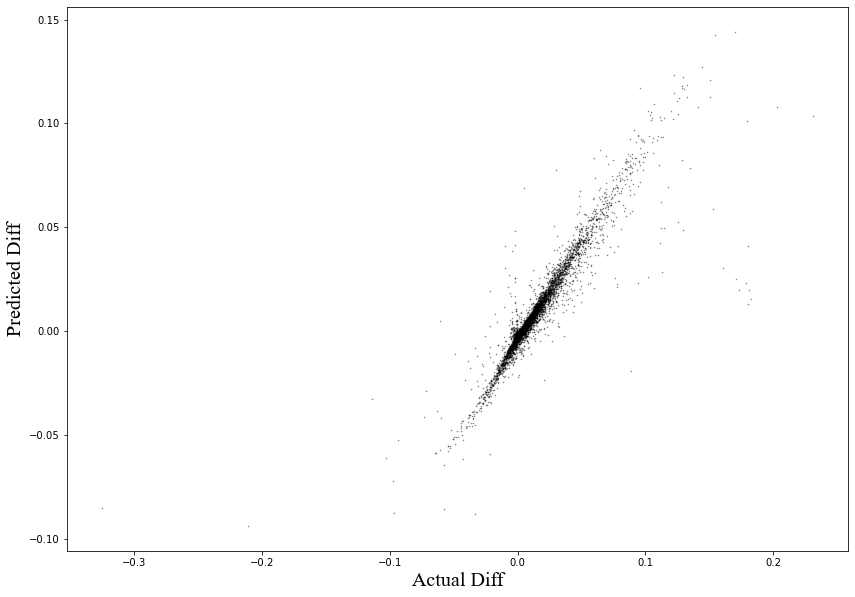

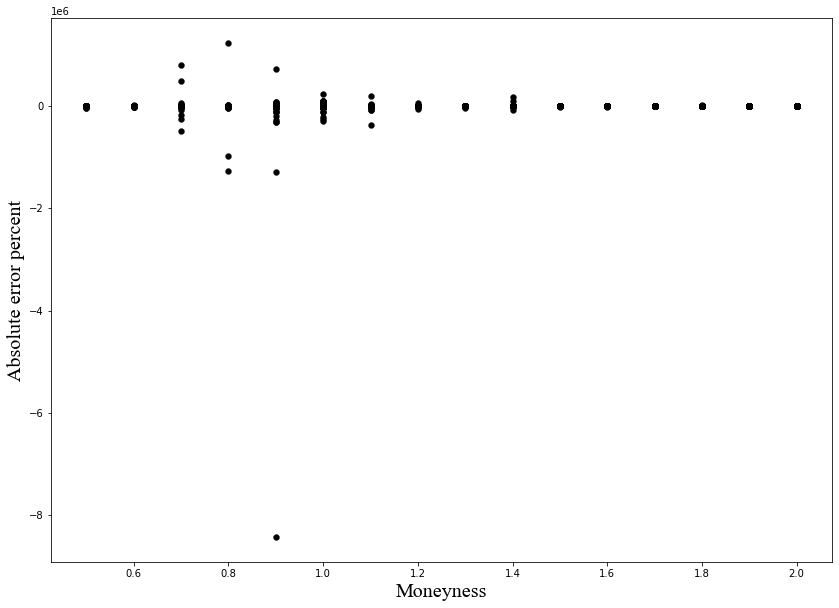

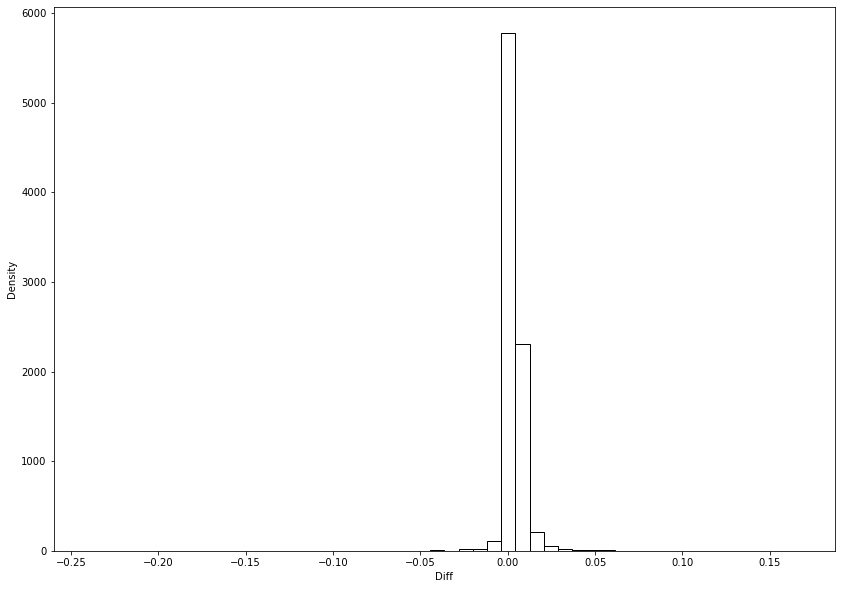

{'diff': array([ 0.0077087 ,  0.00455195, -0.0050912 , ...,  0.00297275,
         0.00259279,  0.00303695], dtype=float32),
 'Error percent': array([   23.528429,   107.38916 ,    24.514568, ..., -4917.7983  ,
            9.629825,    17.298386], dtype=float32),
 'mse': 8.297109e-05,
 'rmse': 0.009108847,
 'mae': 0.0049047936}

In [333]:
y_test_hat = np.squeeze(model(x_test))
y_test_np = y_test.numpy()
y_test_hat_np = y_test_hat.detach().numpy()
check_accuracy(y_test_np, y_test_hat_np, x_test.numpy()[:,4])

### Post Evaluation

In [336]:
def draw_trisurf(x, y, z, title, x_axis='K', y_axis='T'):
    fig = plt.figure(figsize =(16, 9))  
    ax = plt.axes(projection ='3d')  

    # Creating color map
    my_cmap = plt.get_cmap('RdBu_r')

    # Creating plot
    trisurf = ax.plot_trisurf(x, y, z,
                             cmap = my_cmap,
                             linewidth = 0.2, 
                             antialiased = True,
                             edgecolor = 'grey')  
    fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
    ax.set_title(title)
    ax.set_xlabel(x_axis, fontsize=15, rotation=60)
    ax.set_ylabel(y_axis, fontsize=15, rotation=60)
    ax.set_zlabel(title, fontsize=15)
    plt.show()

### in the following part, we try to show:

#### Test set
#### 1. Absolute value difference between Hagan and FDM, on the dimension of K and T
#### 2. True difference/ FDM vol percentage, on the dimension of K and T
#### 3. Predicted  difference/ FDM vol percentage, on the dimension of K and T
#### 4. Predicted  FDM vol / FDM vol percentage, on the dimension of K and T
#### 5. Predicted  difference/ FDM vol percentage, on the dimension of K and T
#### 6. Predicted  diff error / FDM vol percentage, on the dimension of K and T
#### 7. Predicted  diff error/ FDM vol percentage, on the dimension of $\beta$ and $\rho$

In [337]:
pd.DataFrame(x_test.detach().numpy()[:, 6]).describe()

,0
count,8576.000000
mean,0.379167
std,0.121963
min,0.119231
25%,0.289518
50%,0.366291
75%,0.449819
max,1.043713


                  0
count  8.576000e+03
mean   1.188008e-02
std    1.830251e-02
min    3.171379e-08
25%    8.145607e-04
50%    3.975176e-03
75%    1.484675e-02
max    1.000000e-01


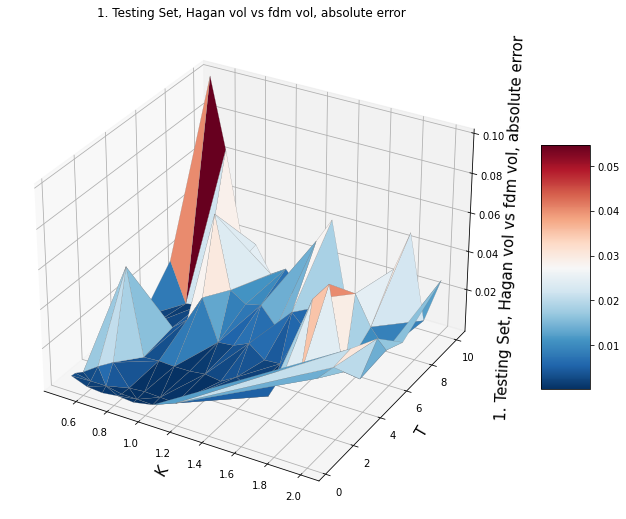

In [338]:
z = np.abs(y_test.detach().numpy())
for i in range(0, len(z), 1):
    if z[i] > 0.1:
        z[i] = 0.1
x = x_test.detach().numpy()[:, 4]
y = x_test.detach().numpy()[:, 5]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '1. Testing Set, Hagan vol vs fdm vol, absolute error')

                 0
count  8576.000000
mean      3.261539
std       5.801594
min       0.000010
25%       0.242973
50%       1.139023
75%       4.088736
max     100.000000


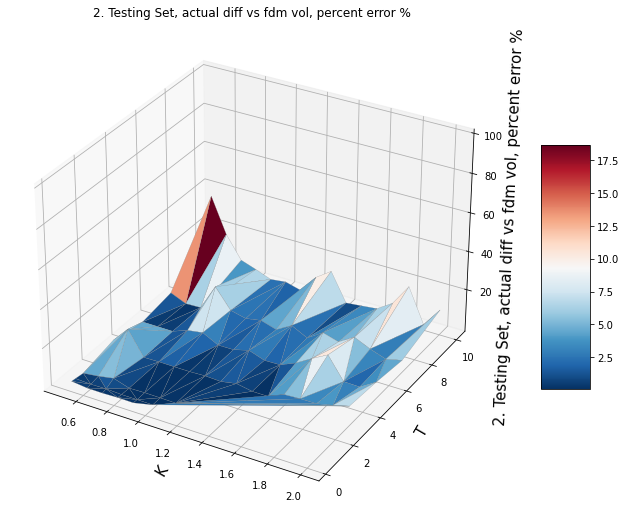

In [339]:
z = np.abs(y_test.detach().numpy() / (x_test.detach().numpy()[:, 6] - y_test.detach().numpy())) * 100
for i in range(0, len(z), 1):
    if z[i] > 100:
        z[i] = 100
x = x_test.detach().numpy()[:, 4]
y = x_test.detach().numpy()[:, 5]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '2. Testing Set, actual diff vs fdm vol, percent error %')

                 0
count  8576.000000
mean      2.786176
std       4.099293
min       0.000086
25%       0.480534
50%       1.027544
75%       3.347629
max      36.682308


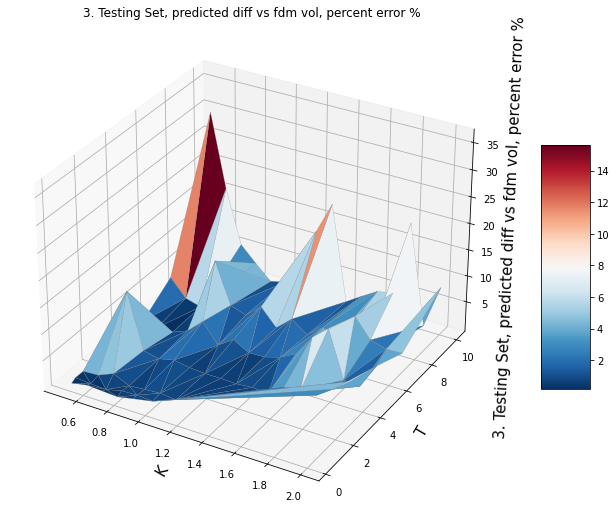

In [340]:
z = np.abs(y_test_hat.detach().numpy() / (x_test.detach().numpy()[:, 6] - y_test.detach().numpy())) * 100
for i in range(0, len(z), 1):
    if z[i] > 100:
        z[i] = 100
x = x_test.detach().numpy()[:, 4]
y = x_test.detach().numpy()[:, 5]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '3. Testing Set, predicted diff vs fdm vol, percent error %')

                 0
count  8576.000000
mean     99.943062
std       0.529128
min      82.498695
25%     100.000000
50%     100.000000
75%     100.000000
max     100.000000


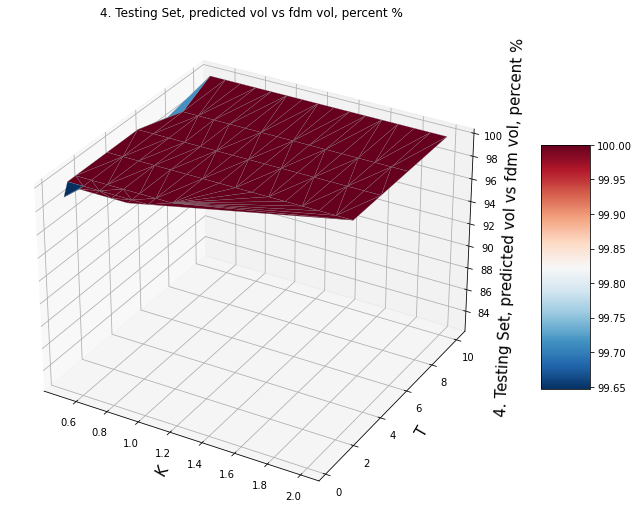

In [341]:
z = np.abs((x_test.detach().numpy()[:, 6]-y_test_hat.detach().numpy())) / (x_test.detach().numpy()[:, 6] - y_test.detach().numpy()) * 100
for i in range(0, len(z), 1):
    if z[i] > 100:
        z[i] = 100
x = x_test.detach().numpy()[:, 4]
y = x_test.detach().numpy()[:, 5]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '4. Testing Set, predicted vol vs fdm vol, percent %')

                  0
count   8576.000000
mean     -21.752750
std      943.252747
min   -84269.351562
25%        0.072099
50%        0.100000
75%        0.100000
max        0.100000


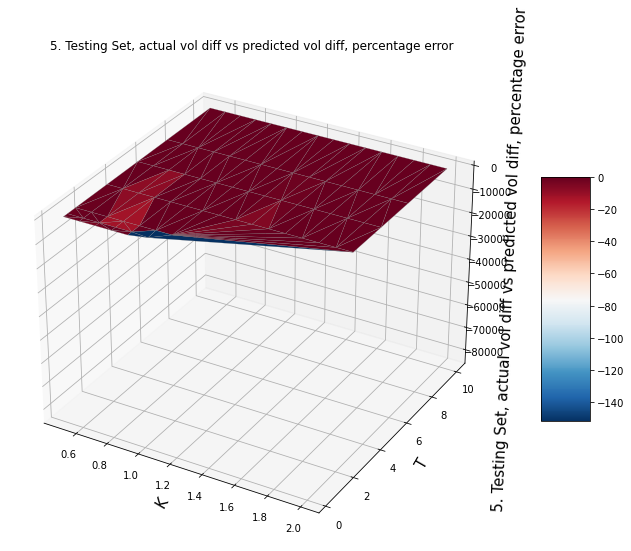

In [342]:
z = np.abs((y_test.detach().numpy() - y_test_hat.detach().numpy()))/y_test.detach().numpy()
for i in range(0, len(z), 1):
    if z[i] > 0.1:
        z[i] = 0.1
x = x_test.detach().numpy()[:, 4]
y = x_test.detach().numpy()[:, 5]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '5. Testing Set, actual vol diff vs predicted vol diff, percentage error')

                 0
count  8576.000000
mean      1.457547
std       3.258704
min       0.000141
25%       0.646157
50%       0.985987
75%       1.584615
max     100.000000


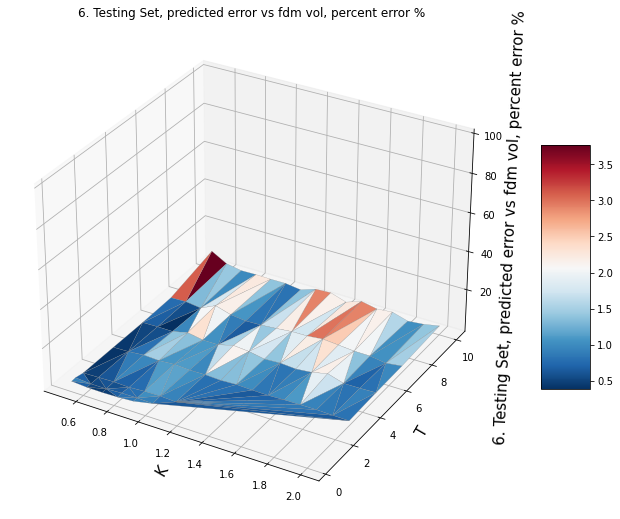

In [343]:
# ['alpha', 'nu', 'beta', 'rho', 'strike', 'tenor', 'floch_vol']
z = np.abs((-y_test.detach().numpy() + y_test_hat.detach().numpy())) / (x_test.detach().numpy()[:, 6] - y_test.detach().numpy()) * 100
for i in range(0, len(z), 1):
    if z[i] > 100:
        z[i] = 100
x = x_test.detach().numpy()[:, 4]
y = x_test.detach().numpy()[:, 5]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '6. Testing Set, predicted error vs fdm vol, percent error %', 'K', 'T')

                 0
count  8576.000000
mean      1.457547
std       3.258704
min       0.000141
25%       0.646157
50%       0.985987
75%       1.584615
max     100.000000


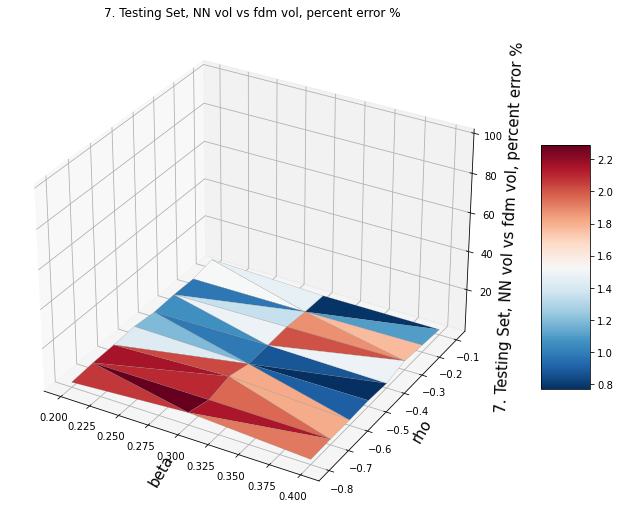

In [344]:
# ['alpha', 'nu', 'beta', 'rho', 'strike', 'tenor', 'floch_vol']
z = np.abs((y_test.detach().numpy() - y_test_hat.detach().numpy())) / (x_test.detach().numpy()[:, 6] - y_test.detach().numpy()) * 100
for i in range(0, len(z), 1):
    if z[i] > 100:
        z[i] = 100
x = x_test.detach().numpy()[:, 2]
y = x_test.detach().numpy()[:, 3]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '7. Testing Set, NN vol vs fdm vol, percent error %', 'beta', 'rho')

In [463]:
# possible test params range
alphas = df_train.alpha.unique()
betas= df_train.beta.unique()
rhos= df_train.rho.unique()
nus= df_train.nu.unique()
strikes= df_train.strike.unique()
tenors = df_train.tenor.unique()

def plot_vol(alpha=0.3, beta=0.3, nu=0.9, rho=-0.8, strikes=strikes, tenor=1, dummy='hagan', model= model, data=data):
    """
    params:
    
    alpha, beta, nu, rho : fixed params which selected from possible params range
    strikes: all possible strike in the training dataset
    dummy: floch method or hagan method
    model: well trained NN model 
    df_train: original training dataset ( without split into training and test)
    """
    #actual_fdm_vol = df.query('alpha == alphap and beta== beta_p and rho== rho_p and tenor== tenor_p and nu==nu_p')['fdm_vol'].unique()
    actual_fdm_vol = data.loc[(data.alpha == alpha)& (data.beta== beta) & (data.rho== rho) & (data.tenor== tenor)& (data.nu==nu)]['fdm_vol'].unique()
    hagan_vol=[ql.sabrVolatility(strike,1,tenor,alpha,beta, nu, rho) for strike in strikes]
    floch_vol=[ql.sabrFlochKennedyVolatility(strike,1,tenor,alpha,beta,nu,rho) for strike in strikes]
    if dummy== 'hagan':
        x_test = {'alpha': alpha,'nu' : nu, 'beta': beta,'rho' : rho, 'strike': strikes,
                  'tenor' : tenor, dummy : hagan_vol}
    else:
        x_test = {'alpha': alpha,'nu' : nu, 'beta': beta,'rho' : rho, 'strike': strikes,
                  'tenor' : tenor, dummy : floch_vol}
        
    x_test= torch.tensor(pd.DataFrame.from_dict(x_test).values,dtype=torch.float)
    
    fdm_diff = np.squeeze(model(x_test)).detach().numpy()
    if dummy=='hagan':
        fdm_vol = hagan_vol - fdm_diff
    else:
        fdm_vol = floch_vol - fdm_diff
    
    ## plot
    dummy_label = dummy + '_predict_fdm'
    plt.plot(strikes,hagan_vol,linestyle='dashed',marker='^',label='Hagan_sabr',color='green')
    plt.plot(strikes,floch_vol,linestyle='dashed',marker='o',label='floch_sabr',color='orange')
    plt.plot(strikes,fdm_vol,linestyle='solid',marker='^',label=dummy_label,color = 'blue')
    plt.plot(strikes,actual_fdm_vol,linestyle='dashed',marker='o',label='actual_fdm',color = 'red')
    plt.legend()
    plt.show()

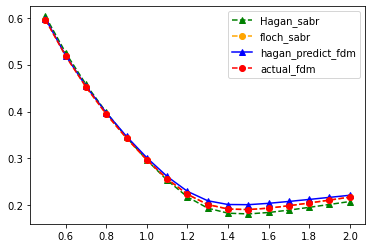

In [456]:
plot_vol(0.3, 0.3, 0.9, -0.8, strikes, 1, 'hagan', model, data)

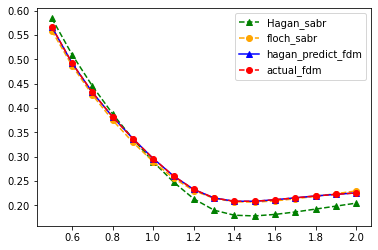

In [391]:
plot_vol(0.3, 0.3, 0.9, -0.8, strikes, 3, 'hagan', model, df_train)

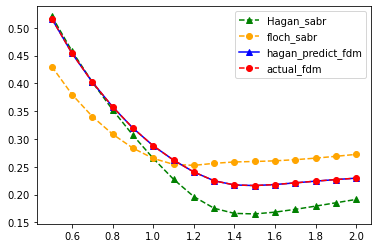

In [392]:
plot_vol(0.3, 0.3, 0.9, -0.8, strikes, 10, 'hagan', model, df_train)

### Model 2: The training target would be to minimize the difference between Floch method and finite difference method

In [474]:
y = df_train['diff_floch']
x = df_train[['alpha', 'nu', 'beta', 'rho', 'strike', 'tenor', 'floch_vol']]
x_train, x_test, y_train, y_test=model_selection.train_test_split(x, y, test_size=0.25)

x_train=torch.tensor(x_train.values,dtype=torch.float)
x_test=torch.tensor(x_test.values,dtype=torch.float)
y_train=torch.tensor(y_train.values,dtype=torch.float)
y_test=torch.tensor(y_test.values,dtype=torch.float)

In [475]:
model=torch.nn.Sequential(
        torch.nn.Linear(7,20),
        torch.nn.Linear(20,100),
        torch.nn.Linear(100,400),
        torch.nn.Sigmoid(),
        torch.nn.Linear(400,10),
        torch.nn.Tanh(),
        torch.nn.Linear(10,1),
        torch.nn.Tanh())

optimizer=optim.Adam(model.parameters(), lr=0.001)
n_epochs = 80
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(x_train, y_train.view(-1, 1))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

for epoch in range(n_epochs):
    for i, (features, price) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(features.float())
        loss = torch.nn.functional.mse_loss(output,price)
        loss.backward()
        optimizer.step()

Mean Squared Error:       5.843272e-05
Root Mean Squared Error:  0.00764413
Mean Absolute Error:      0.0033021527


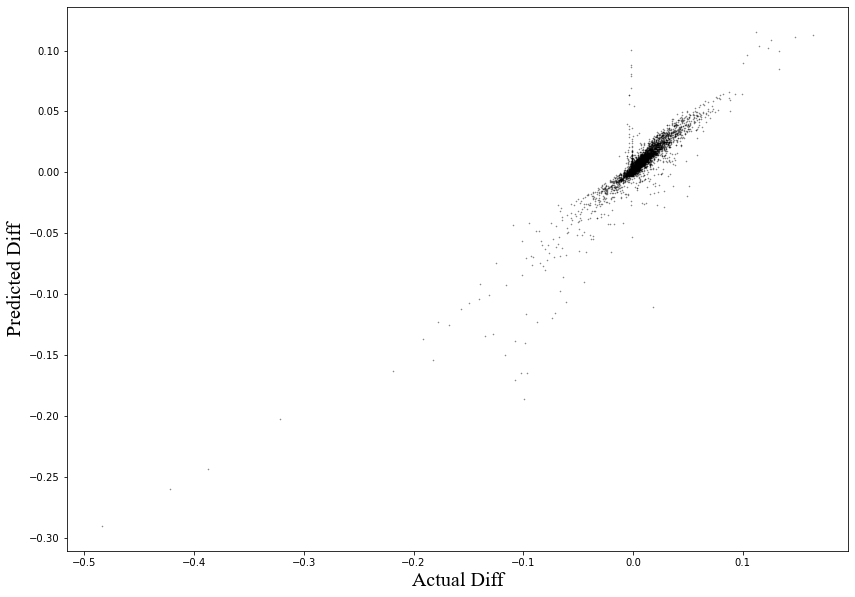

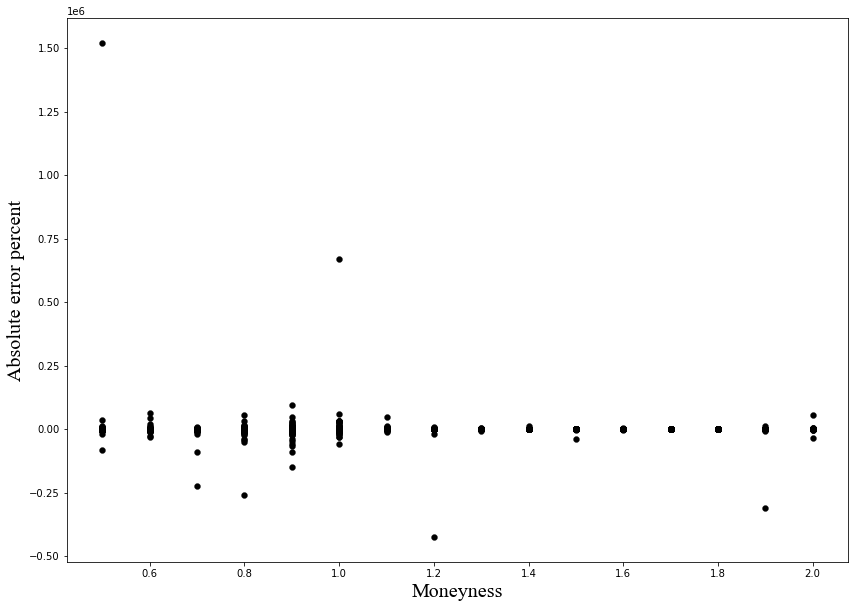

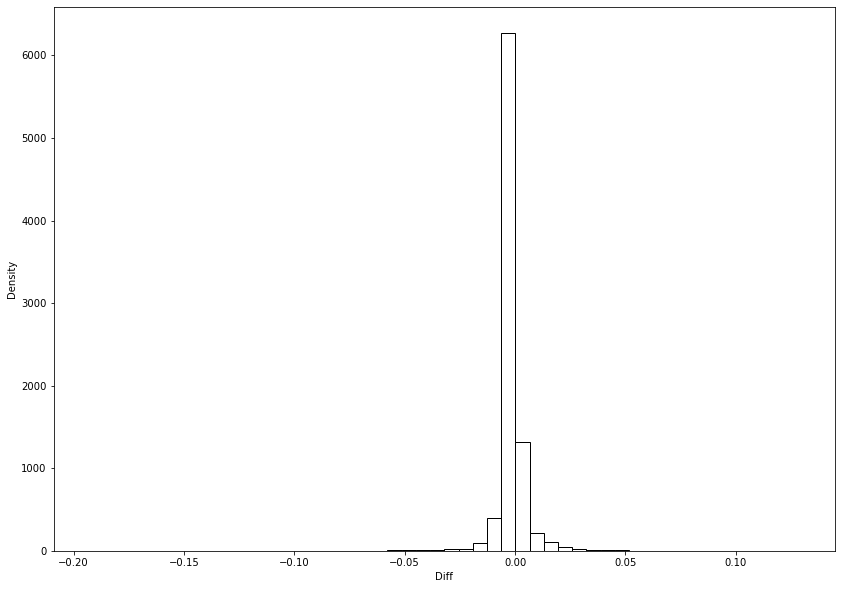

{'diff': array([-1.6614205e-04, -1.0515910e-03, -1.1552947e-03, ...,
        -3.8357917e-03, -3.7613288e-03,  1.2375429e-05], dtype=float32),
 'Error percent': array([-327.1017   ,   31.922493 ,  910.5771   , ...,   52.99758  ,
          25.45388  ,   -7.4816546], dtype=float32),
 'mse': 5.843272e-05,
 'rmse': 0.00764413,
 'mae': 0.0033021527}

In [476]:
y_test_hat = np.squeeze(model(x_test))
y_test_np = y_test.numpy()
y_test_hat_np = y_test_hat.detach().numpy()
check_accuracy(y_test_np, y_test_hat_np, x_test.numpy()[:,4])

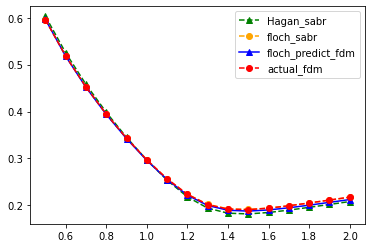

In [477]:
plot_vol(0.3, 0.3, 0.9, -0.8, strikes, 1, 'floch', model, data)

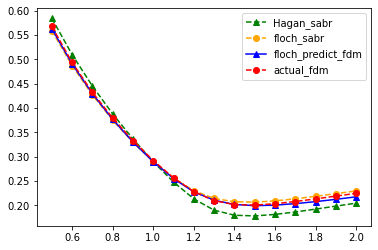

In [478]:
plot_vol(0.3, 0.3, 0.9, -0.8, strikes, 3, 'floch', model, data)

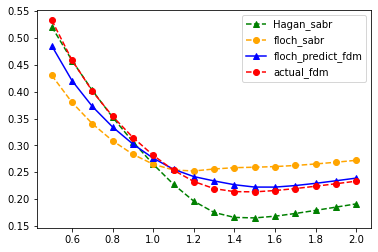

In [479]:
plot_vol(0.3, 0.3, 0.9, -0.8, strikes, 10, 'floch', model, data)